<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Homework 03 - Diffusion Maps</div><br>
    <div style="font-size: large">Authors</div>Luis Antonio Ortega Andrés<br>Antonio Coín Castro</div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [4]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used.

In [29]:
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.datasets import make_blobs, make_swiss_roll, make_s_curve

from mpl_toolkits.mplot3d import Axes3D
Axes3D

matplotlib.rc('figure', figsize=(15, 5))

seed = 123
my_cmap = plt.cm.Spectral

# Introduction

This practical assignment consists in implementing the manifold learning method **Diffusion Maps**, following the *scikit-learn* template for manifold learning methods.

We will design two main functions: one for training the algorithm, obtaining the affinity matrix and the embedded coordinates, and a second one for extending these coordinates for new patterns.

# Requirements

The objective of this assignment is to complete the class DM sketched below, which should contain at least the following methods.

`__init__(self, sigma, n_components, step=1, alpha=1)`

* This is the construction method for the class, with the following parameters:
    * `sigma`: Kernel parameter for the Gaussian kernel.
    * `n_components`: dimension of the embedding.
    * `step`: step in the Markov Chain.
    * `alpha`: density influence. It should a value in `[0,1]`.
* This method should only store the parameters in fields of the class, to be used when needed.

`fit(self, X, y=None)`

* This is the training method, the one that performs the Diffusion Maps algorithm. 

* This method should store the affinity matrix and also the eigenvectors to computed the transformation.

`fit_transform(self, X, y=None)`

* This method returns the embedding coordinates for the training data.
* It should also store the affinity matrix and the coordinates needed to compute the transformation (for example over new, unseen patterns).

`transform(self, X)`

* This method will obtain approximated coordinates for new, unseen data points. 
* It uses for this purpose the Nyström Formula.

## Some recommendations

* It should allow to fix all the DM possibilities (different steps, density normalization...). To allow a change in the kernel function could be also a nice idea.
* Implement all the auxiliary functions that you may need, for example, for deciding the best parameter values in each case.
* It could be a nice idea to offer a deterministic output, that do not depend on the sign of the eigenvectors.

# Implementation

<div class="qst">

* Complete the `DM` class below, satisfying the described requirements.

</div>

**TODO**

- usar SVD flip y seed para tener output determinístico
- permitir varios kernels estándar, también cualquier función de kernel (callable) y también la opción de 'precomputed'

In [138]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist, squareform

class DM(TransformerMixin, BaseEstimator):
    """Diffusion Maps algorithm for manifold learning.
    
    We use the data to define a weighted graph based on  
    similarity, define a random walk over the graph, and 
    use the transition probabilities to find an embedding
    to a 
    
    [1] Coifman, R. R., & Lafon, S. (2006). Diffusion maps. 
        Applied and computational harmonic analysis, 21(1), 5-30.
    """
    def __init__(
        self, 
        n_components=2,
        step=1, 
        alpha=1.0,
        # Change this to GP kernel using sigma??
        kernel = None,
        sigma = None
    ):
        # Assignment of the hyper-parameters (you can complete it).
        self.sigma = sigma
        self.n_components = n_components
        self.step = step
        self.alpha = alpha
        if sigma is not None:
            self.kernel = lambda x, y : rbf_kernel(x, y, gamma = 1/np.sqrt(2)*sigma)
        else: 
            self.kernel = kernel or rbf_kernel
            

    def fit(self, X, y=None):
        """Compute the embedding vectors for data X
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        self : returns an instance of self.
        """
        
        # compute kernel matrix
        kernel_matrix = self.kernel(X, X)

        # Degree vector
        degree_vector = np.sum(kernel_matrix, axis = 1).reshape(-1,1)
        
        # Density normalization
        d_alpha = np.power(degree_vector, self.alpha)
        kernel_matrix = kernel_matrix/(d_alpha@d_alpha.T)
        
        # Transition probability matrix
        P = kernel_matrix/np.sum(kernel_matrix, axis = 1)
        
        # Eigenvals, and vectors decomposition
        e_values, e_vectors = np.linalg.eig(P)
        idx = e_values.argsort()[::-1]
        self.e_values = e_values[idx][1:self.n_components+1].reshape(-1,1)
        self.e_vectors = e_vectors[:,idx[1:self.n_components+1]]
        
        # Define transition matrix (not needed??)
        # P = e_values*(e_vectors/sqrt_pi @ e_vectors.T*sqrt_pi)
        
        # Define diffusion matrix  
        """
        D_{i,j} = \sum_{l} \lambda_l^2 ((\phi_l)_i - (\phi_l)_j)^2 = 
                = \sum_{l} ((\lambda_l \phi_l)_i - (\lambda_l \phi_l)_j)^2 = 
                = pairwise_dist( \lambda * \phi, \lambda * \phi  )
        """
        D = pdist(np.power(e_values,self.step)*e_vectors.T, metric='sqeuclidean')
        D = squareform(D)
        
        # Diffusion coordinates
        diff_coordinates = np.power(e_values, self.step)*e_vectors
        
        
        return self

    def fit_transform(self, X, y=None):
        """Compute the embedding vectors for data X and transform X.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        y : Ignored
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        
        self.fit(X)
        
        X_red = np.power(self.e_values, self.step)*self.e_vectors.T
        
        return X_red.T
    
    def transform(self, X):
        """Transform X.
        This is implemented using the Nyström formula.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features).
        Returns
        -------
        X_red : array-like, shape (n_samples, n_components)
        """
        
        return X_red

# Experiments with DM

<div class="qst">

* Obtain some good embedded coordinates for the three training datasets specified below.
    
* Extend its coordinates for the new points.
    
</div>

## Dataset 1: two blobs

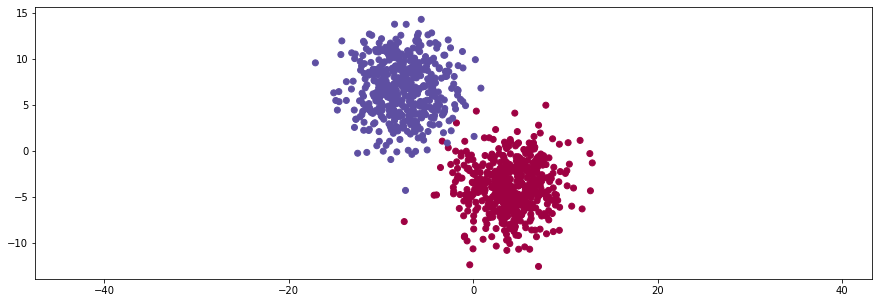

In [139]:
N = 1000

X, y = make_blobs(n_samples=N, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed)
y[y != 1] = -1
plt.scatter(X[:,0], X[:,1], c=y, cmap=my_cmap)
plt.axis('equal')
plt.show()

N_new=100
X_new, y_new = make_blobs(n_samples=N_new, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed+1)

In [140]:
dm = DM()
X_red = dm.fit_transform(X, y)

In [141]:
X_red.shape

(1000, 2)

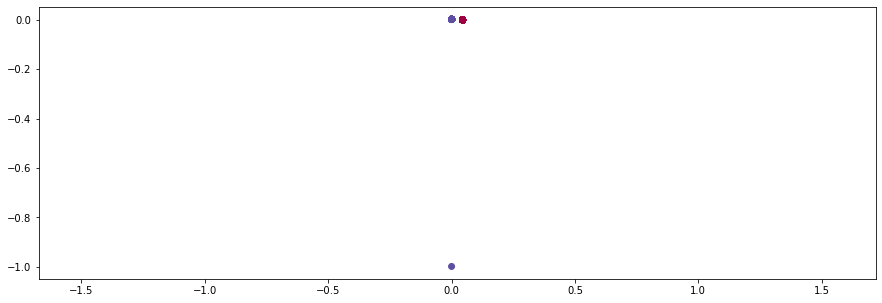

In [142]:
plt.scatter(X_red[:,0], X_red[:,1], c=y, cmap=my_cmap)
plt.axis('equal')
plt.show()

## Dataset 2: the swiss roll

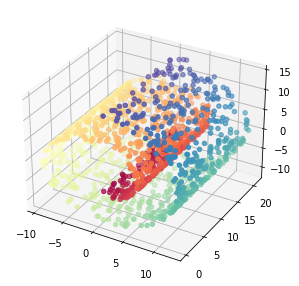

In [4]:
N=1500
X, color = make_swiss_roll(n_samples=N, random_state=seed)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new=100
X_new, color_new = make_swiss_roll(n_samples=N_new, random_state=seed+1)

## Dataset 3: the S curve

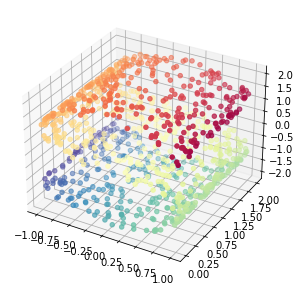

In [5]:
N = 1000
X, color = make_s_curve(N, random_state=seed)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.show()

N_new = 100
X_new, color_new = make_s_curve(N_new, random_state=seed+1)

<div class="qst">

* Do you consider the embedding obtained is good for the previous datasets? Is it the expected one? Why?
    
* How sensible is the method to its hyper-parameters? Specify the best values that you have found and the technique employed for it.
    * Check how much influence the sample density (you can vary N for each dataset).
    * Check what happens if the number of steps `steps` grows.
    
* What do you think are the main advantage and disadvantage of this method?
    
</div>